In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from os.path import join
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import unidecode
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from sklearn.manifold import TSNE
from adjustText import adjust_text

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [2]:
def clean_text(text, stopwords = stopwords.words('spanish')):
    # Remove special characters
    text = re.sub('\W+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove spaces
    text = text.strip()
    # Replace multiple spaces with single space
    text = re.sub(' +', ' ', text)
    # Remove accents
    text = unidecode.unidecode(text)
    # Remove stopwords
    spanish_stopwords = [unidecode.unidecode(w) for w in stopwords]
    words_without_stopwords = [w for w in text.split() if not w in spanish_stopwords]
    text = ' '.join(words_without_stopwords)

    return text 

In [3]:
# Read the data
path = r'/Users/carlosandresosorioalcalde/Documents/GitHub/Borges/Borges'
df = pd.read_excel(join(path, 'stories.xlsx'))

In [4]:
# Clean the content of the stories
df['story'] = df['story'].map(lambda x: clean_text(x))

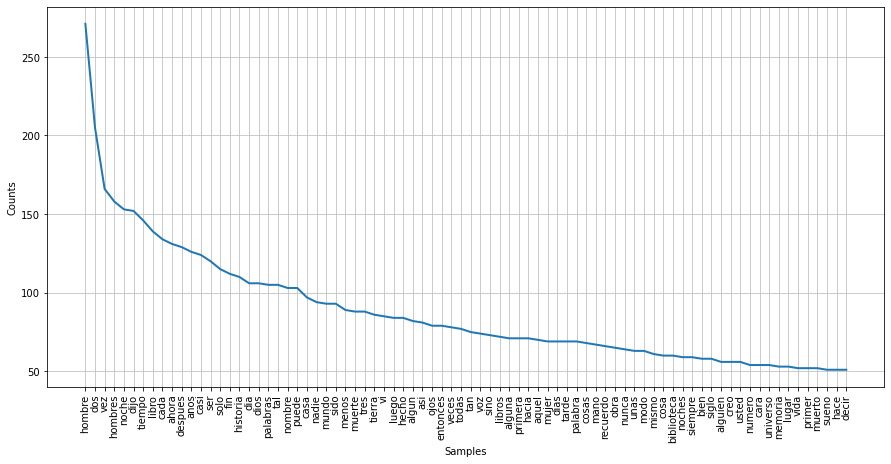

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [5]:
# Create the wordcloud content
stories_content = ' '.join(df['story'])

# Plot the most common words
n_top_words = 80
plt.figure(figsize=(15, 7))
nltk.FreqDist(stories_content.split()).plot(n_top_words)

In [6]:
# Manual stopwords
manual_stopwords = [ 
    'dos',
    'vez',
    'tres',
    'dijo',
    'cada',
    'casi',
    'tal',
    'sido',
    'vi',
    'asi',
    'tan',
    'sino',
    'hacia',
    'unas',
    'hace',
    'decir',
    'and',
    'd',
    '1',
    'quedo',
    'deja',
    'siete',
    'cinco',
    'cuatro',
    'ocho',
    'aqui',
    'haber',
    'dije',
    'pagina',
    'libro'
]

# Clean the content (again) of the stories
df['story'] = df['story'].map(lambda x: clean_text(x, manual_stopwords))

In [7]:
# Create the sentences
sentences = df['story'].map(lambda x : x.split())

In [8]:
# Instantiate the Word2Vec model
model_w2v = Word2Vec(
    sentences, 
    window = 5, 
    min_count = 3, 
    workers = 4,
    alpha = 0.01
)

# Train the model
model_w2v.train(
    sentences,
    total_examples = model_w2v.corpus_count,
    epochs = 100
)

(3343258, 4801800)

In [209]:
def tsne(model, perplexity = 1):
    "Creates and TSNE model"
    labels = []
    tokens = []

    for word in list(model.wv.index_to_key):
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    return new_values, labels

def plot_tsne(new_values, labels, similar_words, coord_label_words):
    dicc_new_values_labels = dict(zip(labels, new_values))
    x = new_values[:, 0]
    y = new_values[:, 1]

    plt.figure(figsize=(15, 15)) 
    plt.box(False)
    plt.scatter(x, y, s = 30, color = 'skyblue', alpha = 0.35)

    for i, label in enumerate(similar_words):
        x_word = dicc_new_values_labels[label][0]
        y_word = dicc_new_values_labels[label][1]
        plt.scatter(
                x_word, 
                y_word, 
                label=label, 
                s = 160, 
                color = 'tomato',
                edgecolors='black',
                alpha = .9
            )

        plt.annotate(
            label,
            xy=(x_word, y_word),
            xytext=(coord_label_words[i][0], coord_label_words[i][1]),
            textcoords='data',
            ha='right',
            va='bottom',
            arrowprops=dict(arrowstyle="-",connectionstyle='arc3,rad=0.5', lw=1.5),
            size = 23,
            bbox=dict(boxstyle="round", fc="none", ec="gray")
        )
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.show()

def similar_words(word_highlight):
    return [word[0] for word in model_w2v.wv.most_similar(word_highlight, topn = 4)] + [word_highlight]

In [16]:
# Fit the t-SNE model to the data
new_values, labels = tsne(model_w2v, perplexity = 95)

/Users/carlosandresosorioalcalde/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/carlosandresosorioalcalde/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


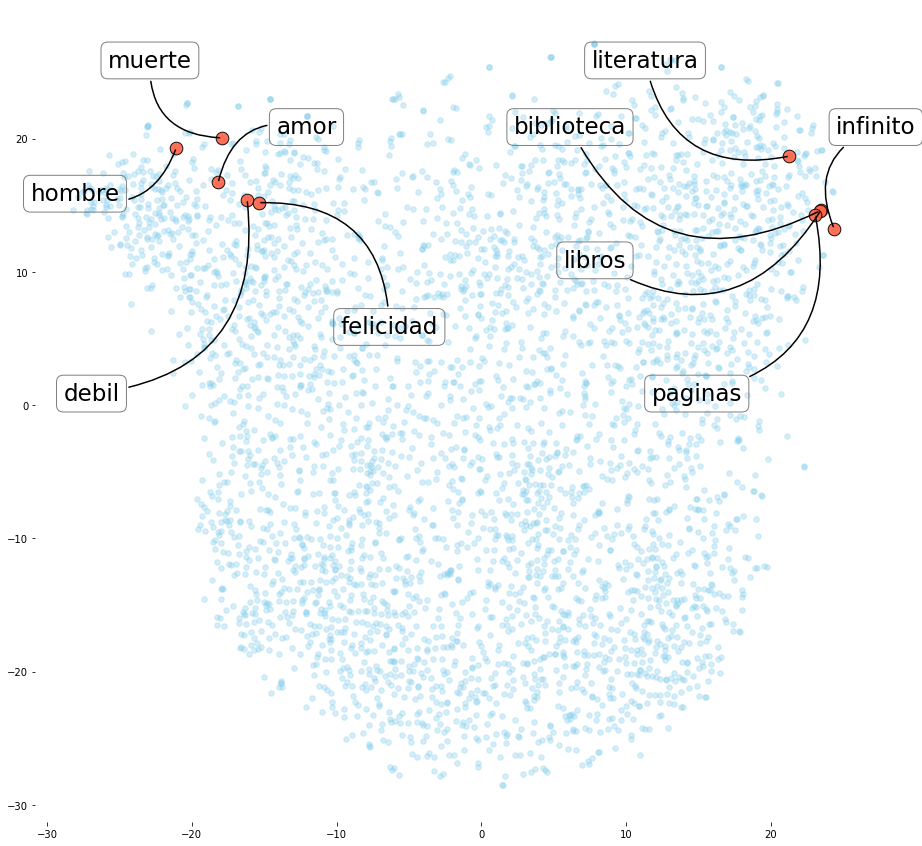

In [210]:
# Get the plot 
#similar_words = similar_words('biblioteca')
from types import coroutine


similar_words = ['infinito', 'libros', 'biblioteca', 'paginas', 'hombre', 'muerte', 'amor',  'literatura', 'debil', 'felicidad']
coord_label_words = [
    (30, 20),
    (10, 10),
    (10, 20),
    (18, 0),
    (-25, 15),
    (-20, 25),
    (-10, 20),
    (15, 25),
    (-25, 0),
    (-3, 5)
]


plot_tsne(
    new_values,
    labels,
    similar_words,
    coord_label_words
)